The Objective functions we may optimize.

In [1]:
include("MyCode.jl")
using DynamicPolynomials, MultivariatePolynomials, FastChebInterp, StaticArrays, LinearSolve, LinearAlgebra, Plots, IterativeSolvers, .MyCode

deuf(x) = (exp(x[1]^2 + x[2]^2) - 3)^2 + (x[1] + x[2] - sin(3 * (x[1] + x[2])))^2
rosenbrock(x, p=2) = 1 / 4 * (x[1] - 1)^2 + abs(x[2] - x[1]^2)^p + abs(x[3] - x[2]^2)^p
dumb(x) = 4*x[1]^4 -2x[1]*x[2]^2 - 8*x[2]^3 + 6*x[1]*x[2] -x[1] -x[2]


dumb (generic function with 1 method)

### Generate Sample Set
Define the boundaries and sampling domain. This method is very slow at producing the Vandermonde Matrix. 
The generation of the sample points is wrong?
I don't understand what goes wrong. The QR decomposition to solve the least squares problem works in python. Maybe specify the method used to solve the linear algebra problem. 


In [ ]:
## Generate matrix of evaluations -- Need to generate sample data ##
# lb = [-3, -3]
# ub = [3, 3]
lb = [-1, -1]
ub = [1, 1]
K = 50
d = 35
x, y = @polyvar x y
M2 = createMonomialContainer([x, y], d)

S1, A1, V1 = comb_mat_vec(K, deuf, M2, lb, ub)  ##  Chebpoints construction 
S2, A2, V2 = grid_mat_vec(K, deuf, M2, lb, ub)  ##  grid construction
m1, n1 = size(A1)
m2, n2 = size(A2)
print(m1, "\n")
print(m2, "\n")
print(length(M2))


### Generate Least-Squares polynomial

In [124]:
sq_A1 = A1' * A1 # generate the least squares system # Chebpoints
f_square_eval1 = A1' * V1
sq_A2 = A2' * A2 # generate the least squares system # Grid square 
f_square_eval2 = A2' * V2

prob_sq1 = LinearProblem(sq_A1, f_square_eval1)
prob_sq2 = LinearProblem(sq_A2, f_square_eval2)
sol_square1 = LinearSolve.solve(prob_sq1, method=:gmres, verbose=true)
sol_square2 = LinearSolve.solve(prob_sq2, method=:gmres, verbose=true)
nrm_cheb = norm(A1*sol_square1.u - V1, 2) 
nrm_grid = norm(A2*sol_square2.u - V2, 2)
print(nrm_cheb)
print("\n",nrm_grid)

198.99600136822477
90.25094628498984

With QR Decomposition

In [125]:
QR1 = qr(sq_A1)
Q1 = Matrix(QR1.Q)
R1 = QR1.R

QR2 = qr(sq_A2)
Q2 = Matrix(QR2.Q)
R2 = QR2.R

RHS1 = Q1' * A1' * V1
RHS2 = Q2' * A2' * V2

prob_qr1 = LinearProblem(R1, RHS1)
prob_qr2 = LinearProblem(R2, RHS2)

sol_square3 = LinearSolve.solve(prob_qr1, method=:gmres, verbose=true)
sol_square4 = LinearSolve.solve(prob_qr2, method=:gmres, verbose=true)


retcode: Default
u: 666-element Vector{Float64}:
  0.5318303717014259
 -0.5357861514038625
 -0.7679642212045685
  2.0502966495156154
 -0.9527825676049752
 -0.3052793627269382
 -2.490570628740256
  0.6780597475534937
  1.7611593439816906
 -0.2809229784236571
  ⋮
  0.6339004016990998
  0.8381214675307647
  0.5187642205214678
  1.168249310497499
  1.6004348969616737
  0.870498395131616
  2.663334006778017
  2.651035793205051
  0.47566250573857666

Try the Krylov Package

In [80]:
using Krylov
X= Krylov.gmres(sq_A1 , f_square_eval1; verbose=1)

GMRES: system of size 378
 pass      k     ‖rₖ‖   hₖ₊₁.ₖ  timer
    0      0  2.3e+04  ✗ ✗ ✗ ✗  0.00s
    1      1  2.4e+03  1.2e+03  0.00s
    1      2  1.2e+03  6.3e+02  0.00s
    1      3  7.6e+02  8.3e+02  0.00s
    1      4  5.8e+02  8.0e+02  0.00s
    1      5  4.3e+02  7.4e+02  0.00s
    1      6  3.5e+02  8.5e+02  0.00s
    1      7  3.0e+02  6.3e+02  0.00s
    1      8  2.6e+02  7.4e+02  0.00s
    1      9  2.3e+02  5.8e+02  0.00s
    1     10  2.0e+02  7.2e+02  0.00s
    1     11  1.8e+02  7.4e+02  0.00s
    1     12  1.6e+02  5.4e+02  0.00s
    1     13  1.4e+02  9.0e+02  0.00s
    1     14  1.3e+02  5.1e+02  0.00s
    1     15  1.2e+02  7.2e+02  0.00s
    1     16  1.1e+02  6.7e+02  0.00s
    1     17  1.1e+02  4.5e+02  0.00s
    1     18  9.9e+01  4.7e+02  0.00s
    1     19  9.2e+01  5.6e+02  0.00s
    1     20  8.5e+01  5.1e+02  0.00s
    1     21  8.0e+01  4.5e+02  0.00s
    1     22  7.5e+01  5.3e+02  0.00s
    1     23  7.1e+01  4.0e+02  0.00s
    1     24  6.8e+01  3

([0.39572929740120105, 1.8839520111550503, -1.4415868576929654, 0.2521118266478288, 1.235481268970744, -0.5275145574719426, 1.217579447168965, 0.1369040297255405, 0.36248614267201074, -0.26203061367645236  …  -0.5489061235369269, 0.6086883521313452, 0.11358516894559645, -0.18658552112101665, 0.10759891935632847, -0.4282266694275956, -1.2018663359740789, -0.14683024158408783, 1.7209587190542517, 1.0757452775200842], SimpleStats
 niter: 200
 solved: true
 inconsistent: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 timer: 11.06ms
 status: solution good enough given atol and rtol
)

### Plots of the samples

In [5]:
# print(size(S))
# scatter(S[:,1], S[:, 2])

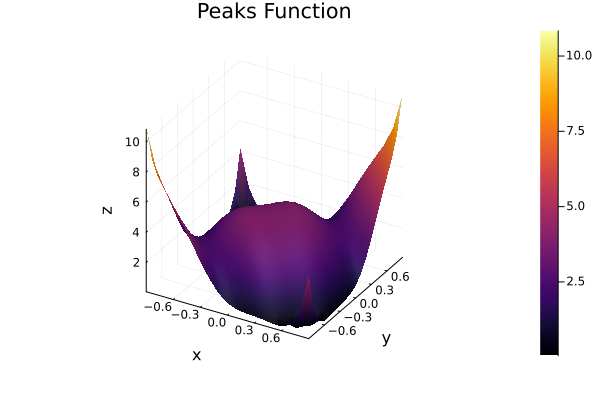

In [115]:
# Generate a grid of points
per = 0.9
X = per*lb[1]:0.1:per*ub[1]
Y = per*lb[2]:0.1:per*ub[2]
Z = [deuf([i, j]) for j in Y, i in X]
surface(X, Y, Z, title="Peaks Function", xlabel="x", ylabel="y", zlabel="z")

### Set Up Polynomial System

In [126]:
monomials_vector = M2.monomials # Get back  just a vector of monomials
pol_sq_cheb = polynomial(sol_square1.u,  monomials_vector) # Generate the least squares polynomial
pol_sq_grid = polynomial(sol_square2.u, monomials_vector) # Generate the least squares polynomial

pol_qr_cheb = polynomial(sol_square3.u, monomials_vector) # Generate the least squares polynomial
pol_qr_grid = polynomial(sol_square4.u, monomials_vector); # Generate the least squares polynomial

Compute the partials

In [83]:
pol_sq_cheb_d1 = differentiate(pol_sq_cheb, x)
pol_sq_cheb_d2 = differentiate(pol_sq_cheb, y)

pol_sq_grid_d1 = differentiate(pol_sq_grid, x)
pol_sq_grid_d2 = differentiate(pol_sq_grid, y)

pol_qr_cheb_d1 = differentiate(pol_qr_cheb, x)
pol_qr_cheb_d2 = differentiate(pol_qr_cheb, y)

pol_qr_grid_d1 = differentiate(pol_qr_grid, x)
pol_qr_grid_d2 = differentiate(pol_qr_grid, y);

### Evaluate polynomial System on Grid

In [127]:
Z_sq_cheb = [pol_sq_cheb([i, j]) for j in Y, i in X];
Z_sq_grid = [pol_sq_grid([i, j]) for j in Y, i in X];
Z_qr_cheb = [pol_qr_cheb([i, j]) for j in Y, i in X];
Z_qr_grid = [pol_qr_grid([i, j]) for j in Y, i in X];

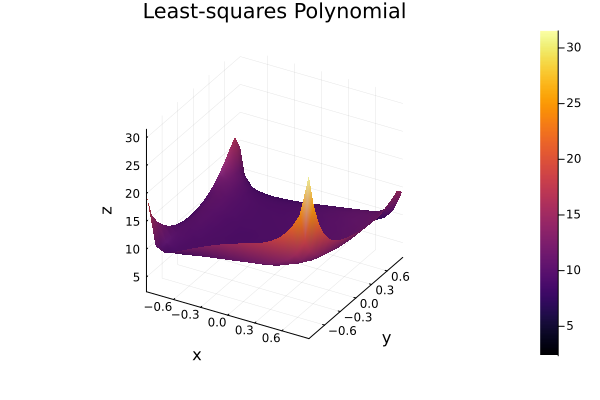

In [128]:
surface(X, Y, Z_sq_cheb, title="Least-squares Polynomial", xlabel="x", ylabel="y", zlabel="z")


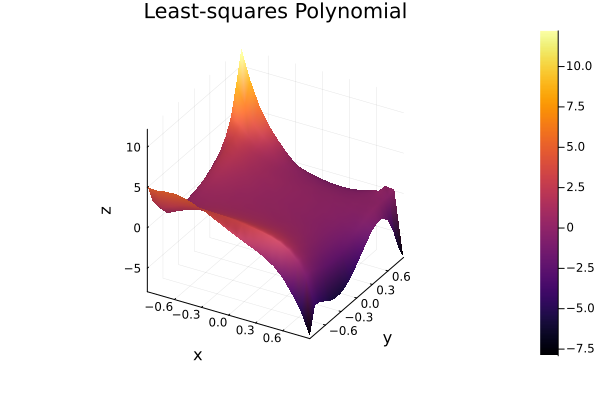

In [129]:
surface(X, Y, Z_sq_grid, title="Least-squares Polynomial", xlabel="x", ylabel="y", zlabel="z")

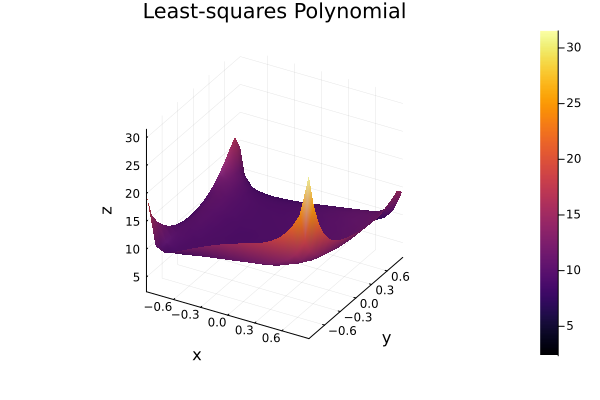

In [130]:
surface(X, Y, Z_qr_cheb, title="Least-squares Polynomial", xlabel="x", ylabel="y", zlabel="z")

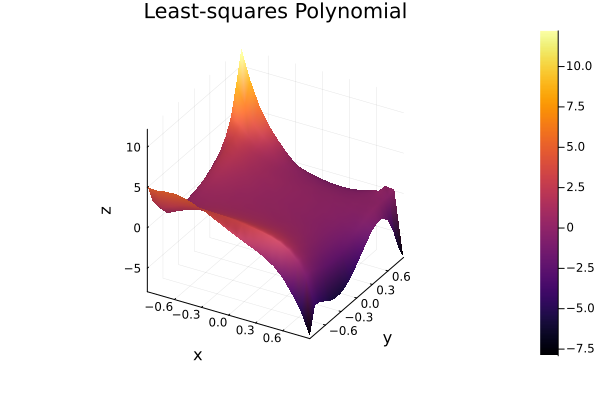

In [131]:
surface(X, Y, Z_qr_grid, title="Least-squares Polynomial", xlabel="x", ylabel="y", zlabel="z")

### Optimization Runs
Could try to use the blackbox optimization package to search for all local extrema. 

In [15]:
#= test =#
using Optim

# Initial guess
x0 = [0.0, 0.0]
x1 = [0.0, -1.0]

# Optimizing Objective functions
result_min = Optim.optimize(peaks, x1)
result_max = Optim.optimize(x -> -peaks(x), x0)
min_value = Optim.minimum(result_min)
max_value = -Optim.minimum(result_max)
min_location = Optim.minimizer(result_min)
max_location = Optim.minimizer(result_max);

### Homotopy Continuation 

Here we could consider immediately converting all coefficients to rational fractions. 

using HomotopyContinuation

Interp_sys = System([p_interp_1, p_interp_2])
Lst_sq_sys = System([p_lst_sq_1, p_lst_sq_2])
## Some homotopy solving ##
res_interp = HomotopyContinuation.solve(Interp_sys)
res_lst_sq = HomotopyContinuation.solve(Lst_sq_sys)
RES_interp = HomotopyContinuation.real_solutions(res_interp; only_real=true, multiple_results=false)
RES_lst_sq = HomotopyContinuation.real_solutions(res_lst_sq; only_real=true, multiple_results=false)

# Extracting x and y coordinates
val = inbound(RES_interp, lb, ub)
x_coords_interp = [point[1] for point in val]
y_coords_interp = [point[2] for point in val]
z_coords_interp = [peaks(point) for point in val]
scatter!(x_coords_interp, y_coords_interp, z_coords_interp, color="green", markersize=4, label="Interpolation")

surface(X, Y, Z_pol_square, title="Least square", xlabel="x", ylabel="y", zlabel="z")